In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy import linalg
from scipy.special import jacobi
import numpy as np

In [2]:
def CreateTriangleLocations(n):
    u = np.linspace(-1,1,n)
    x,y = np.meshgrid(u,u)
    x = x.flatten(); y = y.flatten()
    ind = np.where(x<(-y)+2/n/10)
    return x[ind],y[ind]

def Dubiner(x,y,i,j):
    eta1 = 2*(1+x)/(1-y).clip(1e-12)-1
    eta2 = y
    D    = np.polyval(jacobi(i,0,0),eta1)
    D   *= (0.5*(1-eta2))**i
    D   *= np.polyval(jacobi(j,2*i+1,0),eta2)
    return D

def PrimeBasis(x,y,k=2):
    P = []
    for d in range(k+1):
        for i in range(0,d+1):
            P.append(Dubiner(x,y,i,d-i))
    return np.asarray(P)

Plot the Dubiner basis which we will use as our prime basis for this triangle. 

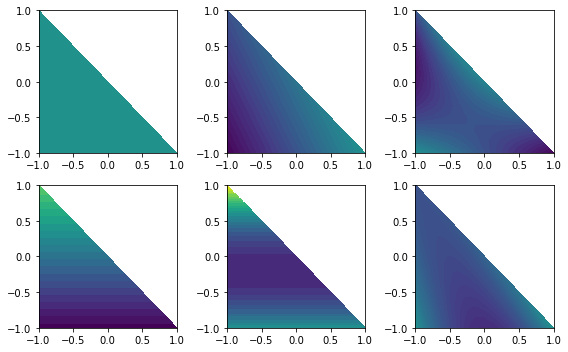

In [3]:
xp,yp = CreateTriangleLocations(31)
T = tri.Triangulation(xp,yp)
P = PrimeBasis(xp,yp)
fig,ax = plt.subplots(figsize=(8,5),nrows=2,ncols=3,tight_layout=True)
for i in range(3):
    for j in range(2):
        k = 2*i+j
        ax[j,i].tricontourf(T,P[k],25,vmin=P.min(),vmax=P.max())

Transform the prime basis to the nodal basis using the generalized Vandermonde matrix and plot the result.

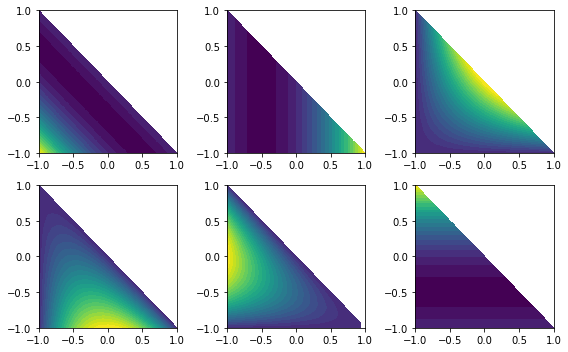

In [4]:
xn,yn = CreateTriangleLocations(3)
V = PrimeBasis(xn,yn)
N = np.linalg.inv(V) @ P # transform to nodal basis
fig,ax = plt.subplots(figsize=(8,5),nrows=2,ncols=3,tight_layout=True)
for i in range(3):
    for j in range(2):
        k = 2*i+j
        ax[j,i].tricontourf(T,N[k],25,vmin=N.min(),vmax=N.max())

Build a constraint matrix by integrating each of the prime basis functions along the bottom edge, multiplied by the quadratic Legendre polynomial. Since the Legendre polynomials of order $k$ are orthogonal to all lower orders, this linear functional will be non-zero only for the $x^2$ term along the bottom edge.

$L_{0,i} = \int_{-1}^{+1} P_i(x,-1) \frac{1}{2}(3x^2-1) dx$

In [5]:
xg,wg = np.polynomial.legendre.leggauss(3)
leg = 0.5*(3*xg**2-1) # legendre polynomial evaulated at quadrature
L = np.asarray([(PrimeBasis(xg,np.ones(xg.size)*-1)*(leg*wg)[np.newaxis,:]).sum(axis=1)])
UL,SL,VL = linalg.svd(L) # will end up using LQ
VL = VL.T[:,1:]          # line above eq (9)

The null space of the constraint matrix will become the new prime basis which is linear on the bottom edge. To plot, we need to construct the reduced nodal basis by removing the node corresponding to the middle of the bottom edge. Then we (1) evaluate the original prime basis at the plotting points (2) transform to the reduced prime basis and then (3) transform by the inverse of the reduced Vandermonde matrix.

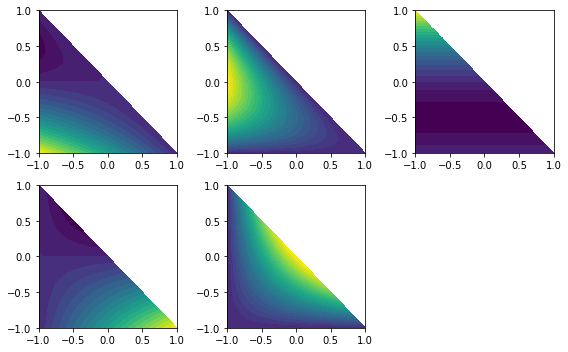

In [6]:
xnr = xn[[0,2,3,4,5]]
ynr = yn[[0,2,3,4,5]]
Vr = VL.T @ PrimeBasis(xnr,ynr) # reduced space Vandermonde matrix
Nr = np.linalg.inv(Vr) @ VL.T @ PrimeBasis(xp,yp) # P --> Pr --> Nr, nodal reduced basis
fig,ax = plt.subplots(figsize=(8,5),nrows=2,ncols=3,tight_layout=True)
for i in range(3):
    for j in range(2):
        k = 2*i+j
        if k == 5: 
            ax[j,i].axis('off')
            continue
        ax[j,i].tricontourf(T,Nr[k],25,vmin=Nr.min(),vmax=Nr.max())

The bottom and top left functions appear to have a linear trace on the bottom edge while the others are zero. We can confirm this by plotting all the functions along the bottom axis.

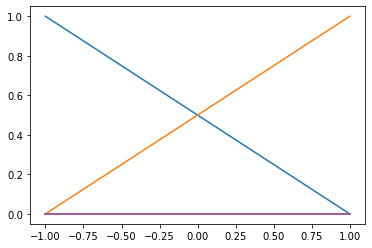

In [7]:
xl = np.linspace(-1,1,101)
yl = np.ones(xl.size)*-1
Nl = np.linalg.inv(Vr) @ VL.T @ PrimeBasis(xl,yl)
for i in range(5): plt.plot(xl,Nl[i])